## Preamble

Run this cell in order to import the necessary libraries run this notebook

In [1]:
# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Modified Alveoli model

+ We treat each alveolus as a bistable system with two states: open and closed.
+ The closed state corresponds to $r=0$ and the open state corresponds to $r=2$.
+ We couple the alveoli with a network of springs, which encourage adjacent alveoli to be in the same state.
+ + Question: is this true? It is at ends with the "Y" shaped alveoli model
+ We define the network connecting the alveoli to have a tree-like geometry
+ We will initialize a subpopulation of alveoli already to be already closed 


Text(0, 0.5, 'Alveoli radius')

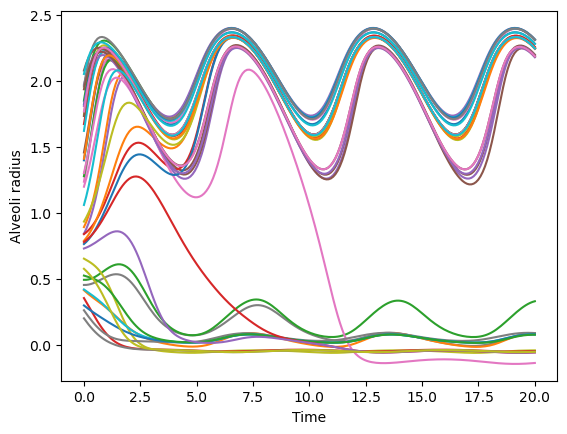

In [2]:
from scipy.integrate import solve_ivp

from models import tree_coupling_matrix


class AlveoliModel:
    """
    The cubic term represents a nonlinear elastic response
    Bistability: collapsed state and open state

    CRPG: pattern generator
    Alveoli model: elastic response function

    Attributes:
        alpha (float or ndarray): the stiffness of the elastic response
        beta (float or ndarray): the nonlinear stiffness of the elastic response
        omega (float or ndarray): the frequency of the forcing
        gamma (float or ndarray): the amplitude of the forcing
        k (float or ndarray): the coupling among alveoli
    """

    def __init__(self, k=1, alpha=1, beta=1, omega=1, gamma=0.1):
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = gamma
        self.k = k
        self.rc = np.sqrt(self.beta / self.alpha)

    def rhs(self, t, X):
        r = X
        # zdot = self.omega
        # force = self.gamma * np.cos(z)
        force = self.gamma * np.cos(self.omega *t)
        rs = r - self.rc
        rdot = 0 
        rdot = 0.1 * force  * r # forcing term
        rdot += -self.alpha * rs ** 3 + self.beta * rs # elastic response
        rdot += self.k @ rs # coupling

        return np.array(rdot)
    
    def solve(self, t, X0):
        self.t = t
        self.X0 = X0
        self.sol = solve_ivp(self.rhs, (t[0], t[-1]), X0, t_eval=t, method='Radau')
        return self.sol


n_nodes = 40
np.random.seed(10)
k = 0.1 * (np.random.random((n_nodes, n_nodes)))
k = 0.1 * tree_coupling_matrix(n_nodes)
# eq = AlveoliModel(gamma=0, k=k) # No forcing
eq = AlveoliModel(gamma=4, k=k)

t = np.linspace(0, 20, 200)
X0 = 2.1 * np.random.random(k.shape[0])
sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

plt.figure()
plt.plot(sol.t, sol.y[:, :].T)
plt.xlabel('Time')
plt.ylabel('Alveoli radius')

## Plot snapshots of the network at several timepoints

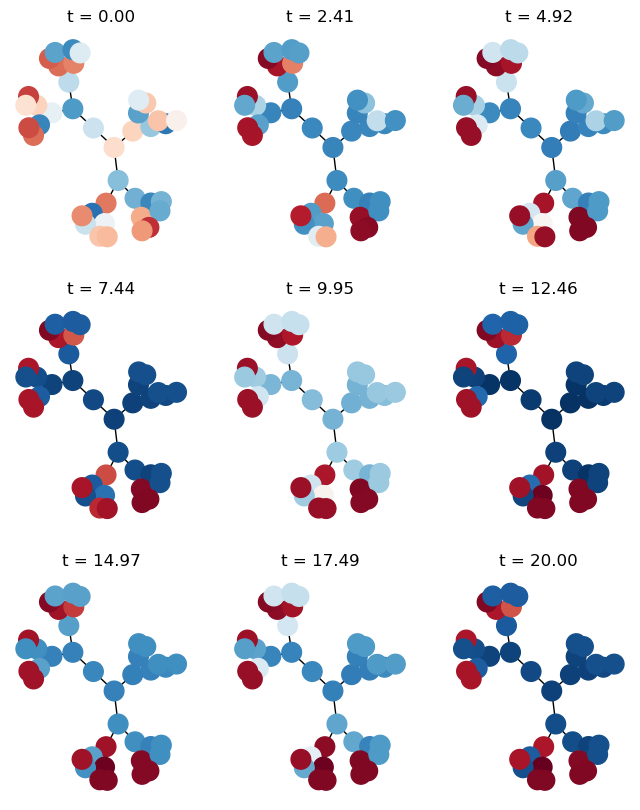

In [3]:

from models import plot_tree

n_plots = 9

plot_time_inds = np.linspace(0, sol.y.shape[1]-1, n_plots).astype(int)
phases = sol.y
phases = (phases - phases.min()) / (phases.max() - phases.min()) # normalize to [0, 1]

# 3 x 3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(8, 10))
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        pos = plot_tree(
            n_nodes, 
            nodecolors=phases[:, plot_time_inds[i]], ax=ax, cmap="RdBu", 
            random_state=0, vmin=0, vmax=1, node_size=200
        )
    else:
        pos = plot_tree(
            n_nodes, 
            nodecolors=phases[:, plot_time_inds[i]], pos=pos, ax=ax, cmap="RdBu", 
            vmin=0, vmax=1, node_size=200
        )
    # label time
    ax.set_title(f"t = {sol.t[plot_time_inds[i]]:.2f}")



# Work on stochastic integration (in progress)

+ This requires simulating an SDE, and is not yet working
+ If we add white noise to the r dynamics, we observe some suppression of the transition to the closed state

In [28]:
import jax.numpy as jnp
import jax.random as jrandom
from diffrax import diffeqsolve, ControlTerm, Euler, EulerHeun, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree


class AlveoliModel:
    """
    The cubic term represents a nonlinear elastic response
    Bistability: collapsed state and open state

    CRPG: pattern generator
    Alveoli model: elastic response function

    Attributes:
        alpha (float or ndarray): the stiffness of the elastic response
        beta (float or ndarray): the nonlinear stiffness of the elastic response
        omega (float or ndarray): the frequency of the forcing
        gamma (float or ndarray): the amplitude of the forcing
        k (float or ndarray): the coupling among alveoli
        eta (float or ndarray): the noise amplitude
    """

    def __init__(self, k=1, alpha=1, beta=1, omega=1, gamma=0.1, eta=0.0):
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = gamma
        self.k = k
        self.rc = np.sqrt(self.beta / self.alpha)
        self.eta = eta

    def rhs(self, t, r):
        force = self.gamma * jnp.cos(self.omega * t)
        rs = r - self.rc

        rdot = 0.1 * force  * r # forcing term
        rdot += -self.alpha * rs ** 3 + self.beta * rs # elastic response
        rdot += self.k @ rs # coupling

        return rdot
    
    def solve(self, t, X0):

        t0, t1 = float(t[0]), float(t[-1])
        drift = lambda t, y, args: self.rhs(t, y)
        # diffusion = lambda t, y, args: 0.5 * t # multiplicative noise
        diffusion = lambda t, y, args: self.eta
        brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jrandom.PRNGKey(0))
        terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
        # solver = Euler()
        solver = EulerHeun()
        # saveat = SaveAt(dense=True)
        saveat = SaveAt(ts=t)

        sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=np.array(X0).copy(), saveat=saveat, max_steps=10000)

        return sol


n_nodes = 128

# k = 0.1 * tree_coupling_matrix(n_nodes)
k = 2 * hyperbolic_coupling_matrix(n_nodes)
k = 0.03 * k / np.max(k, axis=1, keepdims=True)

# weak disperson in frequencies
freqs = np.ones(n_nodes) + 0.01 * np.random.randn(n_nodes)

n_nodes = k.shape[0]
eq = AlveoliModel(gamma=4, k=k, omega=freqs)

t = np.linspace(0, 30, 200)
np.random.seed(1)
X0 = 2.0 * np.random.random(k.shape[0])
# np.random.seed(1)
# X0 = np.random.random(k.shape[0]) + 0.5
sol = eq.solve(t, X0)

Text(0.5, 1.0, 'Alveoli Dynamics  with Noise')

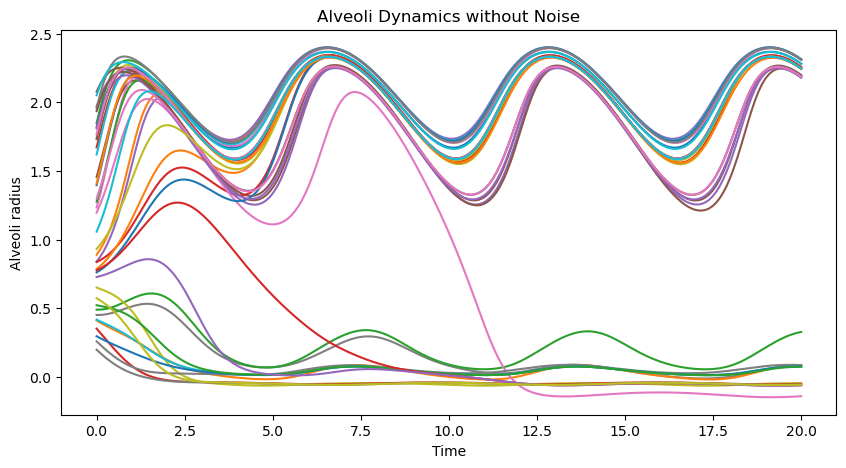

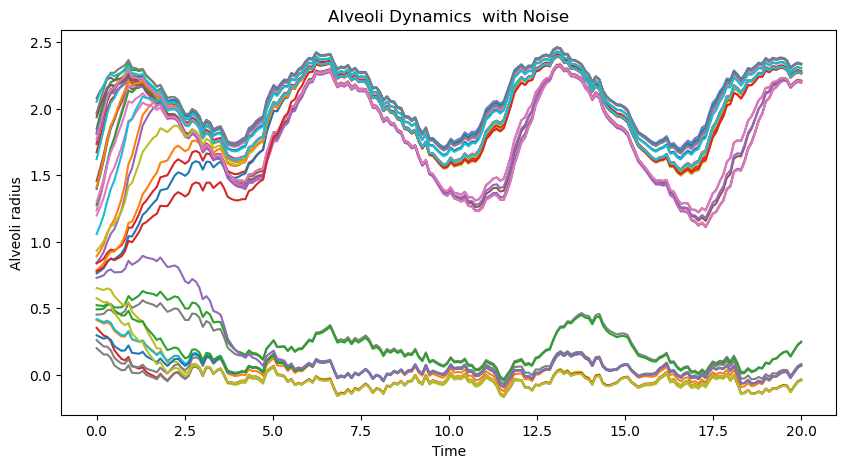

In [31]:
n_nodes = 40
np.random.seed(10)
k = 0.1 * (np.random.random((n_nodes, n_nodes)))
k = 0.1 * tree_coupling_matrix(n_nodes)
# eq = AlveoliModel(gamma=0, k=k) # No forcing

t = np.linspace(0, 20, 200)
X0 = 2.1 * np.random.random(k.shape[0])

eq = AlveoliModel(gamma=4, k=k, eta=0)
sol = eq.solve(t, X0)
plt.figure(figsize=(10, 5))
plt.plot(sol.ts, sol.ys);
plt.xlabel('Time')
plt.ylabel('Alveoli radius')
plt.title('Alveoli Dynamics without Noise')

eq = AlveoliModel(gamma=4, k=k, eta=0.1)
sol = eq.solve(t, X0)
plt.figure(figsize=(10, 5))
plt.plot(sol.ts, sol.ys);
plt.xlabel('Time')
plt.ylabel('Alveoli radius')
plt.title('Alveoli Dynamics  with Noise')

# Place alveoli on the leaves of a tree graph (in progress)

+ We will initialize a subpopulation of alveoli already to be already closed 
+ Issue: mean field dominates, once a majority are open all will open. Conversely, once a majority are closed all will close.
+ What destabilizes mean field? Feedback where when some close, the pressure on the remaining ones increases, causing them to open

In [ ]:
from models import hyperbolic_coupling_matrix

n_nodes = 128

# k = 0.1 * tree_coupling_matrix(n_nodes)
k = 2 * hyperbolic_coupling_matrix(n_nodes)
k = 0.03 * k / np.max(k, axis=1, keepdims=True)

# weak disperson in frequencies
freqs = np.ones(n_nodes) + 0.01 * np.random.randn(n_nodes)

n_nodes = k.shape[0]
eq = AlveoliModel(gamma=4, k=k, omega=freqs)

t = np.linspace(0, 30, 200)
np.random.seed(1)
X0 = 2.0 * np.random.random(k.shape[0])
# np.random.seed(1)
# X0 = np.random.random(k.shape[0]) + 0.5
sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

plt.figure()
plt.plot(sol.t, sol.y[:, :].T)
plt.xlabel('Time')
plt.ylabel('Alveoli radius')

In [ ]:

from models import plot_tree, plot_circle

n_plots = 9

plot_time_inds = np.linspace(0, sol.y.shape[1]-1, n_plots).astype(int)
phases = sol.y
phases = (phases - phases.min()) / (phases.max() - phases.min()) # normalize to [0, 1]

# 3 x 3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

pos = np.zeros((n_nodes, 2))
for i in range(n_nodes):
    pos[i, 0] = np.cos(2 * np.pi * i / n_nodes)
    pos[i, 1] = np.sin(2 * np.pi * i / n_nodes)

for i, ax in enumerate(axs.flatten()):
    ax.scatter(pos[:, 0], pos[:, 1], c=phases[:, plot_time_inds[i]], cmap="RdBu", vmin=0, vmax=1)
    ax.axis('off')
    # pos = plot_circle(
    #     n_nodes,
    #     nodecolors=phases[:, plot_time_inds[i]], ax=ax, 
    #     #cmap="RdBu",
    #     # random_state=0, vmin=0, vmax=1, node_size=200
    # )
    # if i == 0:
    #     pos = plot_tree(
    #         n_nodes, 
    #         nodecolors=phases[:, plot_time_inds[i]], ax=ax, cmap="RdBu", treestyle="leaf",
    #         random_state=0, vmin=0, vmax=1, node_size=50
    #     )
    # else:
    #     pos = plot_tree(
    #         n_nodes, 
    #         nodecolors=phases[:, plot_time_inds[i]], pos=pos, ax=ax, cmap="RdBu",treestyle="leaf",
    #         random_state=0, vmin=0, vmax=1, node_size=50
    #     )
    # label time
    ax.set_title(f"t = {sol.t[plot_time_inds[i]]:.2f}")



# List of papers

https://link.springer.com/chapter/10.1007/0-387-27023-X_44



###  Physiology, Alveolar Tension article
https://www.ncbi.nlm.nih.gov/books/NBK539825/
Alveolar surface tension: proportional to surface tension
+ Many texts treat alveoli as isolated and conneced to single duct. In this case, Laplace's law states that P = 2T/r, where pressure is imposed by the airway, T is surface tension within the alveolus, and r is radius of alveolus.
+ However, newer works suggest clusters of alveoli connected by inter-alveolar septum, similar to a foam or soap bubble. 
+ Alveolar size determined by balance between lung expanding and collapsing forces
+ Lung recoil set by surface tension, which causes the alveoli to rebound to a smaller size
+ Surfactant reduces the surface tension, and forestalls collapse


+ neonatal respiratory distress syndrome = insufficient surfactant production

Under Laplace's law, two isolated connected alveoli will exhibit bistability. If one is larger than another, however, the smaller one will empty into the larger one. This is because the pressure in the smaller one is higher than the pressure in the larger one. However, the reason alveoli do not collapse is because the shrinkage of the smaller alveolus concentrates surfactants, thereby decreasing the surface tension


### Laplace’s law and the alveolus: a misconception of anatomy and a misapplication of physics
https://journals.physiology.org/doi/full/10.1152/advan.00024.2002
Prange 2003
+ Rarely a pressure differential across alveoli, because of inter-alveolar connections.
+ Lungs inflate via negative pressure
+ Negative pressure forces are transmitted uniformly throughout the lung 
+ + Seems to imply instantaneous transmission of forcing pressure
+ Criticizes the "Y" tube model of alveolus


###  Diffusion on Fractals, 
Shaughnessy, Procaccia, 1985
https://journals.aps.org/pra/abstract/10.1103/PhysRevA.32.3073
Diffusion equation on fractals:
$$
    \dfrac{d}{dt}P(r, t) = \dfrac{1}{r^{D-1}} \, \dfrac{d}{dr}\left(    K r^{D-1-\theta}    \dfrac{d}{dr}P(r, t)    \right)
$$
where $D$ is the dimension of the fractal, and $\theta$ is the fractal dimension of the surface. On the fractal, the mean-square displacement is given by
$$
    \langle r^2(t) \rangle \propto t^{2/(2+\theta)}
$$
For a regular Euclidena lattice $\theta=0$, and so we recover the usual result $\langle r^2(t) \rangle \propto t$. On a regular binary tree, $\theta=1$ and $D=1$, and so $\langle r^2(t) \rangle \propto t^{2/3}$ and
$$
    \dfrac{d}{dt}P(r, t) =  K \dfrac{d}{dr}\left(   r^{-1}    \dfrac{d}{dr}P(r, t)    \right)
$$



In [ ]:
# Simulate laplace's law with two connected spheres

class Alveolus:

    def __init__(self, radius=1, ):
        self.radius = radius
        self.pressure = pressure